In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import islice

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

y = train_df['target']
feature_columns = ['keyword', 'location', 'text']
X = train_df[feature_columns]

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)

train_X = train_X.fillna('NoValue') # we do this at the top ...
val_X = val_X.fillna('NoValue') # we do this at the top ...
#train_X.describe()
#val_X.head(100)
#train_y.head(10)
#val_y.head(10)



In [2]:
import re #library for regular expression operations
import string #for string operations
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import html

def process_tweet_str(s):
    # started with code from DeepLearning AI NLP course.
    # this is optimized for tweets
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    #clean character encoding
    s = re.sub(r'[^\x00-\x7F]','', s)
    #unescape html 
    s = html.unescape(s)
    # remove stock market tickers like $GE
    s = re.sub(r'\$\w*', '', s)
    # remove old style retweet text "RT"
    s = re.sub(r'^RT[\s]+', '', s)
    # remove hyperlinks    
    s = re.sub(r'https?://[^\s\n\r]+', '', s)
    # remove some common words
    common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']
    s = ' '.join(i for i in s.split() if i not in common_words)
    # remove hashtags
    # only removing the hash # sign from the word
    s = re.sub(r'#', '', s)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(s)
    result = []
    for word in tokens:
        if (word not in stopwords_english   # remove stopwords
                and word not in string.punctuation  # remove punctuation
                    and not word.isdigit()):  
            stem_word = stemmer.stem(word)  # stemming word
            result.append(stem_word)

    return result

def process_df(df): 
    result = {}
    for index, df_row in df.iterrows():
        result_row ={}
        result_row['text'] = process_tweet_str(df_row['text'])
        result_row['keyword'] = process_tweet_str(df_row['keyword'])
        result_row['location'] = process_tweet_str(df_row['location'])
        result[index]=result_row
    return result

processed_words_train_X = process_df(train_X)

#for id, row in all_preprocessed_tweets.items():
#    print(f'all_preprocessed_tweets[{id}]=\"{row}\"')

In [3]:
def build_freqs(processed_rows, targets):
    freqs = {'text':{}, 'keyword':{}, 'location':{}}
    for id, row in processed_rows.items():
        target=targets[id]
        for t,f in freqs.items():
            for word in row[t]:
                pair = (word, target)
                if pair in f:
                    f[pair] += 1
                else:
                    f[pair] = 1
    return freqs

freqs = build_freqs(processed_words_train_X, train_y)


#for freq_type in ['text','keyword','location']:
#    for key,value in islice(freqs[freq_type].items(),10): 
#        print(f'freqs[\'{freq_type}\'][{key}]={value}')

In [4]:
# add new feature in train_X: the sum of positive freqs
# add new feature in train_X: the sum of negative freqs

train_X = train_X.assign(keyword_freq_sum_positive=0)
train_X = train_X.assign(keyword_freq_sum_negative=0)
train_X = train_X.assign(location_freq_sum_positive=0)
train_X = train_X.assign(location_freq_sum_negative=0)
train_X = train_X.assign(text_freq_sum_positive=0)
train_X = train_X.assign(text_freq_sum_negative=0)

def calc_freq_sums(words, freq_type):
    positive_sum = 0
    negative_sum = 0
    for word in words:
        positive_sum+= freqs[freq_type].get((word,1),0)
        negative_sum+= freqs[freq_type].get((word,0),0)
    return {'positive': positive_sum, 'negative': negative_sum}


for i, row in islice(train_X.iterrows(),100):
    #------- keyword ---------
    freq_sums = calc_freq_sums(processed_words_train_X[i]['keyword'], 'keyword')
    train_X.loc[i,'keyword_freq_sum_positive']= freq_sums['positive']
    train_X.loc[i,'keyword_freq_sum_negative']= freq_sums['negative']
    #------- location ---------
    freq_sums = calc_freq_sums(processed_words_train_X[i]['location'], 'location')
    train_X.loc[i,'location_freq_sum_positive']= freq_sums['positive']
    train_X.loc[i,'location_freq_sum_negative']= freq_sums['negative']
    #------- text ---------
    freq_sums = calc_freq_sums(processed_words_train_X[i]['text'], 'text')
    train_X.loc[i,'text_freq_sum_positive']= freq_sums['positive']
    train_X.loc[i,'text_freq_sum_negative']= freq_sums['negative']

for i, row in islice(train_X.iterrows(),0):
    print (f'i={i}')
    print(row)
train_X.describe()

,keyword_freq_sum_positive,keyword_freq_sum_negative,location_freq_sum_positive,location_freq_sum_negative,text_freq_sum_positive,text_freq_sum_negative
count,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000
mean,0.471100,0.434319,6.246634,8.252545,3.984893,3.039901
std,5.022587,3.905103,71.613598,94.797212,45.907654,30.830694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131.000000,64.000000,873.000000,1155.000000,1286.000000,729.000000


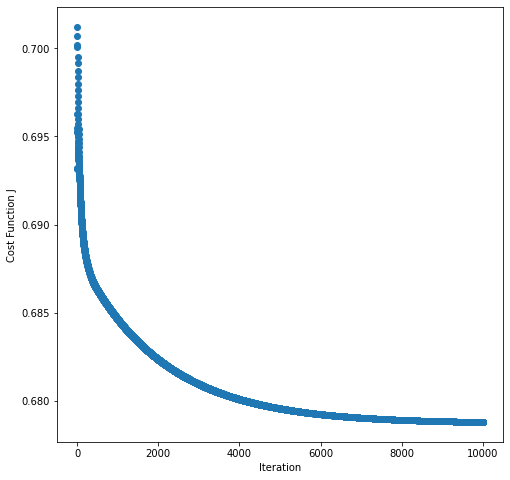

The cost after training is 0.67880503.
The resulting vector of weights is [-0.25432925, 0.01590321, -0.00227467, -0.0256174, 0.01960693, 0.02105071, -0.02526826]


In [5]:
def sigmoid(z): 
    h = 1 / (1 + np.exp(-z))
    return h

def gradientDescent(x, y, theta, alpha, num_iters):
    m = x.shape[0]
    
    i_plot = range(0,num_iters)
    J_plot=[]
    
    for i in range(0, num_iters):
        z = np.dot(x,theta)
        h = sigmoid(z)        
        # calculate the cost function
        J = -1/m * ( np.dot(y.T,np.log(h))+np.dot((1-y).T, np.log(1-h)))
        J_plot.append(float(J))
        # update the weights theta
        theta = theta - alpha / m * np.dot(x.T, h-y)
    J = float(J)

    if True:
        import matplotlib.pyplot as plt 
        fig2, ax2 = plt.subplots(figsize = (8, 8))
        # Plot a dot for each pair of words
        ax2.scatter(i_plot, J_plot)
        plt.xlabel("Iteration")
        plt.ylabel("Cost Function J")
        plt.show()
   
    
    return J, theta


#logistic regression
train_X = train_X.assign(bias=1)
X = train_X[['bias', 'keyword_freq_sum_positive', 'keyword_freq_sum_negative', 'location_freq_sum_positive', 'location_freq_sum_negative', 'text_freq_sum_positive', 'text_freq_sum_negative']].values
Y = train_y.values
Y = Y.reshape(Y.shape[0],1)
J, theta = gradientDescent(X, Y, np.zeros((7, 1)), 1e-3, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")



In [6]:
def extract_features(df_row, freqs):
    freq_sums_keyword = calc_freq_sums(process_tweet_str(df_row['keyword']), 'keyword')
    freq_sums_location = calc_freq_sums(process_tweet_str(df_row['location']), 'location')
    freq_sums_text = calc_freq_sums(process_tweet_str(df_row['text']), 'text')
    x = np.zeros((1, 7))     
    x[0,0] = 1 #bias
    x[0,1] = freq_sums_keyword['positive']
    x[0,2] = freq_sums_keyword['negative']
    x[0,3] = freq_sums_location['positive']
    x[0,4] = freq_sums_location['negative']
    x[0,5] = freq_sums_text['positive']
    x[0,6] = freq_sums_text['negative']
    assert(x.shape == (1, 7))
    return x


def extract_features_old(tweet, freqs):
    word_l = process_tweet(tweet)
    x = np.zeros((1, 3))     
    #bias term is set to 1
    x[0,0] = 1 
    for word in word_l:
        x[0,1] += freqs.get((word,1.0),0)
        x[0,2] += freqs.get((word,0.0),0)
    assert(x.shape == (1, 3))
    return x

In [7]:
def predict_tweet(tweet_row, freqs, theta):
    # extract the features of the tweet and store it into x
    x = extract_features(tweet_row, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred

In [8]:
def predict_multiple_tweets(x,  freqs, theta):
   # the list for storing predictions
    y_hat = []

    #for i, row in islice(x.iterrows(),10):
    for i, row in x.iterrows():
        # get the label prediction for the tweet
        y_pred = predict_tweet(row, freqs, theta)
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
    y_hat =np.array(y_hat)    
    return y_hat

val_predictions = predict_multiple_tweets(val_X, freqs, theta)

In [9]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, classification_report, confusion_matrix
c = confusion_matrix(val_y.values, val_predictions)
print(c)
calc_precision = c[1,1]/(c[0,1]+c[1,1])
#print(f'calc_precision={calc_precision}')
calc_recall = c[1,1]/(c[1,0]+c[1,1])
#print(f'calc_recall={calc_recall}')

precision = precision_score(val_y.values, val_predictions)
recall = recall_score(val_y.values, val_predictions)
f2 = fbeta_score(val_y.values, val_predictions, beta=2)
print(classification_report(val_y.values, val_predictions))

#print(f'precision={precision}')
#print(f'recall={recall}')
#print(f'f2={f2}')

[[693 189]
 [191 450]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       882
           1       0.70      0.70      0.70       641

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [10]:
def list_misclassified(x,pred_y, y):
    #pred_y = pred_y.reshape(pred_y.shape[0],1)
    #y = y.reshape(y.shape[0],1)
    #print (pred_y.shape)
    #print (y.shape)
    misclassified = {'fp':[], 'fn':[]}    
    i=0
    for id, row in x.iterrows():
        if (pred_y[i] != y[i]): 
            if (pred_y[i]==1):
                misclassified['fp'].append(id)
            else: 
                misclassified['fn'].append(id)
        i+=1
    return misclassified

misclassified_tweets = list_misclassified(val_X, list(val_predictions), list(val_y))           
n = 1
print("FALSE NEGATIVE")
for j in range(n):
    id = misclassified_tweets['fn'][j]
    row = val_X.loc[id]
    keyword = row['keyword']
    processed_keyword = process_tweet_str(keyword)
    location = row['location']
    processed_location = process_tweet_str(location)
    text = row['text']
    processed_text = process_tweet_str(text)
    p = predict_tweet(row, freqs, theta)
    features = extract_features(row, freqs)
    print('---------------------')
    print(f'id={id}')
    print(f'keyword={keyword}')
    print(f'processed_keyword={processed_keyword}')
    print(f'location={location}')
    print(f'processed_location={processed_location}')
    print(f'text={text}')
    print(f'processed_text -->{processed_text}')
    print(f'prediction -->{p}')
    print(f'features -->{features}')

FALSE NEGATIVE
---------------------
id=7464
keyword=wounds
processed_keyword=['wound']
location=cody, austin follows ?*?
processed_location=['codi', 'austin', 'follow']
text=Crawling in my skin
These wounds they will not hea
processed_text -->['crawl', 'skin', 'wound', 'hea']
prediction -->[[0.48022588]]
features -->[[ 1. 28. 29.  8.  8. 37. 37.]]


In [11]:
test_df = test_df.fillna('NoValue')
predictions = predict_multiple_tweets(test_df, freqs, theta)
my_submission = pd.DataFrame({'id': test_df['id'].values, 'target': predictions})
my_submission.to_csv('submission.csv', index=False)
count = my_submission.count()
s = my_submission['target'].sum()
print(f'{s} positives out of {count} predictions')

1438 positives out of id        3263
target    3263
dtype: int64 predictions
